In [1]:
!pip install --quiet torch torchvision torchaudio

import random
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange, tqdm
import os


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device:", device)


Device: cpu


In [3]:
class GridworldEnv:
    """
    3 x 4 gridworld, 0-indexed rows (0..2) top to bottom, cols (0..3) left to right.
    Example layout (rows x cols):
     (0,0) (0,1) (0,2) (0,3)
     (1,0) (1,1) (1,2) (1,3)
     (2,0) (2,1) (2,2) (2,3)
    We'll set terminals at chosen positions; you can change positions easily.
    """
    def __init__(self, rows=3, cols=4, terminal_pos_goal=(0,3), terminal_pos_trap=(1,3),
                 step_reward=-0.04, goal_reward=1.0, trap_reward=-1.0, seed=SEED):
        self.rows = rows
        self.cols = cols
        self.state_size = rows * cols
        self.action_size = 4  # N, S, E, W
        self.step_reward = step_reward
        self.goal_reward = goal_reward
        self.trap_reward = trap_reward
        self.terminal_goal = terminal_pos_goal
        self.terminal_trap = terminal_pos_trap
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)
        self.reset()
        self.action2delta = {0:(-1,0),1:(1,0),2:(0,1),3:(0,-1)}

    def _pos_to_index(self, pos):
        r,c = pos
        return r*self.cols + c

    def _index_to_pos(self, idx):
        r = idx // self.cols
        c = idx % self.cols
        return (r,c)

    def is_terminal_pos(self, pos):
        return pos == self.terminal_goal or pos == self.terminal_trap

    def reset(self, start_pos=(2,0)):
        # default start: bottom-left (2,0) typical in gridworld examples
        self.agent_pos = start_pos
        self.done = False
        return self._state()

    def _state(self):
        # one-hot representation of length state_size
        idx = self._pos_to_index(self.agent_pos)
        vec = np.zeros(self.state_size, dtype=np.float32)
        vec[idx] = 1.0
        return vec

    def step(self, action):
        """
        Action is intended direction. Transitions: intended 0.8, left/right 0.1 each.
        Left/right here are relative to the intended; for N: left=W, right=E; for E: left=N, right=S.
        """
        if self.done:
            return self._state(), 0.0, True, {}

        left_of = {0:3, 1:2, 2:0, 3:1}
        right_of = {0:2, 1:3, 2:1, 3:0}

        probs = [0.0]*4
        probs[action] += 0.8
        probs[left_of[action]] += 0.1
        probs[right_of[action]] += 0.1

        actions = [0,1,2,3]
        chosen = random.choices(actions, weights=probs, k=1)[0]

        delta = self.action2delta[chosen]
        new_r = self.agent_pos[0] + delta[0]
        new_c = self.agent_pos[1] + delta[1]

        if not (0 <= new_r < self.rows and 0 <= new_c < self.cols):
            new_pos = self.agent_pos
        else:
            new_pos = (new_r, new_c)

        self.agent_pos = new_pos

        if self.agent_pos == self.terminal_goal:
            reward = self.goal_reward
            self.done = True
        elif self.agent_pos == self.terminal_trap:
            reward = self.trap_reward
            self.done = True
        else:
            reward = self.step_reward

        return self._state(), float(reward), bool(self.done), {}

    def sample_random_state(self):
        while True:
            r = random.randrange(self.rows)
            c = random.randrange(self.cols)
            if not self.is_terminal_pos((r,c)):
                pos = (r,c)
                idx = self._pos_to_index(pos)
                vec = np.zeros(self.state_size, dtype=np.float32)
                vec[idx] = 1.0
                return vec


In [4]:
Transition = namedtuple('Transition', ('state','action','reward','next_state','done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # convert to tensors
        states = torch.tensor(np.stack([b.state for b in batch]), dtype=torch.float32, device=device)
        actions = torch.tensor([b.action for b in batch], dtype=torch.long, device=device).unsqueeze(1)
        rewards = torch.tensor([b.reward for b in batch], dtype=torch.float32, device=device).unsqueeze(1)
        next_states = torch.tensor(np.stack([b.next_state for b in batch]), dtype=torch.float32, device=device)
        dones = torch.tensor([b.done for b in batch], dtype=torch.float32, device=device).unsqueeze(1)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_sizes=[64,64]):
        super(QNetwork, self).__init__()
        layers = []
        last = state_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU())
            last = h
        layers.append(nn.Linear(last, action_dim))
        self.net = nn.Sequential(*layers)
        # init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        return self.net(x)


In [6]:
env = GridworldEnv()
state_dim = env.state_size
action_dim = env.action_size

params = {
    "episodes": 2000,
    "max_steps": 100,
    "batch_size": 64,
    "gamma": 0.99,
    "lr": 1e-3,
    "replay_capacity": 10000,
    "start_learning_after": 1000,  # steps
    "update_every": 1,             # update on every step after start
    "target_update_freq": 100,     # sync target every N gradient steps
    "epsilon_start": 1.0,
    "epsilon_end": 0.05,
    "epsilon_decay_episodes": 1000,
    "hidden_sizes": [64,64],
    "eval_every": 50,
    "n_eval_episodes": 20
}
params


{'episodes': 2000,
 'max_steps': 100,
 'batch_size': 64,
 'gamma': 0.99,
 'lr': 0.001,
 'replay_capacity': 10000,
 'start_learning_after': 1000,
 'update_every': 1,
 'target_update_freq': 100,
 'epsilon_start': 1.0,
 'epsilon_end': 0.05,
 'epsilon_decay_episodes': 1000,
 'hidden_sizes': [64, 64],
 'eval_every': 50,
 'n_eval_episodes': 20}

In [7]:
# Cell 7 — Training function (DQN-style)
def linear_epsilon(episode, start, end, decay_episodes):
    if episode >= decay_episodes:
        return end
    else:
        return start + (end-start) * (episode/decay_episodes)

def evaluate_policy(qnet, env, n_episodes=20, max_steps=100):
    qnet.eval()
    returns = []
    success = 0
    for _ in range(n_episodes):
        s = env.reset()
        total = 0.0
        for step in range(max_steps):
            s_t = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                qvals = qnet(s_t)
            action = int(torch.argmax(qvals, dim=1).item())
            s, r, done, _ = env.step(action)
            total += r
            if done:
                if r == env.goal_reward:
                    success += 1
                break
        returns.append(total)
    qnet.train()
    return np.mean(returns), np.std(returns), success / n_episodes

def train_dqn(params, verbose=True):
    # create networks, optimizer, buffer
    Q = QNetwork(state_dim, action_dim, hidden_sizes=params['hidden_sizes']).to(device)
    Q_target = QNetwork(state_dim, action_dim, hidden_sizes=params['hidden_sizes']).to(device)
    Q_target.load_state_dict(Q.state_dict())
    optimizer = optim.Adam(Q.parameters(), lr=params['lr'])
    buffer = ReplayBuffer(params['replay_capacity'])

    all_train_returns = []
    all_eval_returns = []
    losses = []
    steps = 0
    grad_steps = 0

    # pre-fill some random transitions
    # Not strictly necessary; we'll fill via interactions
    for ep in trange(params['episodes'], desc="Episodes"):
        s = env.reset()
        episode_return = 0.0
        eps = linear_epsilon(ep, params['epsilon_start'], params['epsilon_end'], params['epsilon_decay_episodes'])

        for t in range(params['max_steps']):
            # epsilon greedy
            if random.random() < eps:
                a = random.randrange(action_dim)
            else:
                with torch.no_grad():
                    s_t = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
                    qvals = Q(s_t)
                    a = int(torch.argmax(qvals, dim=1).item())

            s2, r, done, _ = env.step(a)
            buffer.push(s, a, r, s2, done)
            episode_return += r
            s = s2
            steps += 1

            # learning
            if len(buffer) >= params['batch_size'] and steps >= params['start_learning_after']:
                # perform update
                states, actions, rewards, next_states, dones = buffer.sample(params['batch_size'])
                # compute targets
                with torch.no_grad():
                    q_next = Q_target(next_states)
                    max_q_next, _ = torch.max(q_next, dim=1, keepdim=True)
                    targets = rewards + (1.0 - dones) * params['gamma'] * max_q_next
                q_values = Q(states).gather(1, actions)
                loss = nn.MSELoss()(q_values, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                grad_steps += 1

                # target update
                if grad_steps % params['target_update_freq'] == 0:
                    Q_target.load_state_dict(Q.state_dict())

            if done:
                break

        all_train_returns.append(episode_return)

        # periodic evaluation
        if (ep % params['eval_every'] == 0) or (ep == params['episodes']-1):
            mean_ret, std_ret, succ = evaluate_policy(Q, env, n_episodes=params['n_eval_episodes'], max_steps=params['max_steps'])
            all_eval_returns.append((ep, mean_ret, std_ret, succ))
            if verbose:
                print(f"Ep {ep:4d} | eps {eps:.3f} | train_ret {episode_return:.3f} | eval_mean {mean_ret:.3f} | success {succ:.2f}")

    # package results
    results = {
        'train_returns': np.array(all_train_returns),
        'eval_returns': all_eval_returns,
        'losses': np.array(losses),
        'Q': Q,
        'Q_target': Q_target
    }
    return results

# Run training (this will take a few minutes on CPU, faster on GPU)
results = train_dqn(params)


Episodes:   2%|▏         | 38/2000 [00:00<00:14, 133.22it/s]

Ep    0 | eps 1.000 | train_ret 0.440 | eval_mean -4.000 | success 0.00


Episodes:   3%|▎         | 56/2000 [00:01<00:44, 44.18it/s] 

Ep   50 | eps 0.953 | train_ret -0.640 | eval_mean 0.772 | success 1.00


Episodes:   5%|▌         | 103/2000 [00:04<02:39, 11.92it/s]

Ep  100 | eps 0.905 | train_ret 0.600 | eval_mean 0.732 | success 1.00


Episodes:   8%|▊         | 154/2000 [00:07<01:37, 19.02it/s]

Ep  150 | eps 0.858 | train_ret -0.040 | eval_mean 0.482 | success 1.00


Episodes:  10%|█         | 207/2000 [00:11<01:22, 21.74it/s]

Ep  200 | eps 0.810 | train_ret 0.640 | eval_mean 0.770 | success 1.00


Episodes:  13%|█▎        | 254/2000 [00:13<01:12, 23.94it/s]

Ep  250 | eps 0.762 | train_ret 0.640 | eval_mean 0.392 | success 1.00


Episodes:  15%|█▌        | 303/2000 [00:16<01:30, 18.67it/s]

Ep  300 | eps 0.715 | train_ret -0.560 | eval_mean 0.674 | success 0.95


Episodes:  18%|█▊        | 357/2000 [00:18<00:54, 29.93it/s]

Ep  350 | eps 0.667 | train_ret 0.320 | eval_mean 0.602 | success 0.90


Episodes:  20%|██        | 404/2000 [00:20<01:28, 18.00it/s]

Ep  400 | eps 0.620 | train_ret 0.320 | eval_mean 0.456 | success 1.00


Episodes:  23%|██▎       | 454/2000 [00:22<00:45, 33.95it/s]

Ep  450 | eps 0.573 | train_ret 0.840 | eval_mean 0.768 | success 1.00


Episodes:  25%|██▌       | 506/2000 [00:24<00:47, 31.17it/s]

Ep  500 | eps 0.525 | train_ret 0.760 | eval_mean 0.782 | success 1.00


Episodes:  28%|██▊       | 558/2000 [00:25<00:44, 32.27it/s]

Ep  550 | eps 0.478 | train_ret 0.760 | eval_mean 0.790 | success 1.00


Episodes:  30%|███       | 606/2000 [00:26<00:27, 50.31it/s]

Ep  600 | eps 0.430 | train_ret 0.840 | eval_mean 0.802 | success 1.00


Episodes:  33%|███▎      | 653/2000 [00:28<00:47, 28.33it/s]

Ep  650 | eps 0.383 | train_ret 0.800 | eval_mean 0.498 | success 1.00


Episodes:  35%|███▌      | 708/2000 [00:30<00:27, 47.56it/s]

Ep  700 | eps 0.335 | train_ret 0.840 | eval_mean 0.790 | success 1.00


Episodes:  38%|███▊      | 755/2000 [00:31<00:37, 33.12it/s]

Ep  750 | eps 0.288 | train_ret 0.560 | eval_mean 0.690 | success 0.95


Episodes:  41%|████      | 811/2000 [00:32<00:23, 51.57it/s]

Ep  800 | eps 0.240 | train_ret -1.240 | eval_mean 0.672 | success 0.95


Episodes:  43%|████▎     | 857/2000 [00:33<00:20, 55.36it/s]

Ep  850 | eps 0.193 | train_ret 0.720 | eval_mean 0.684 | success 0.95


Episodes:  45%|████▌     | 905/2000 [00:34<00:31, 35.09it/s]

Ep  900 | eps 0.145 | train_ret 0.760 | eval_mean 0.666 | success 0.95


Episodes:  48%|████▊     | 958/2000 [00:35<00:17, 59.43it/s]

Ep  950 | eps 0.098 | train_ret 0.760 | eval_mean 0.794 | success 1.00


Episodes:  50%|█████     | 1009/2000 [00:36<00:16, 59.24it/s]

Ep 1000 | eps 0.050 | train_ret 0.640 | eval_mean 0.776 | success 1.00


Episodes:  53%|█████▎    | 1052/2000 [00:37<00:25, 36.47it/s]

Ep 1050 | eps 0.050 | train_ret 0.680 | eval_mean 0.304 | success 1.00


Episodes:  56%|█████▌    | 1111/2000 [00:38<00:15, 58.18it/s]

Ep 1100 | eps 0.050 | train_ret 0.840 | eval_mean 0.710 | success 1.00


Episodes:  58%|█████▊    | 1162/2000 [00:39<00:13, 62.51it/s]

Ep 1150 | eps 0.050 | train_ret 0.680 | eval_mean 0.758 | success 1.00


Episodes:  60%|██████    | 1207/2000 [00:40<00:19, 40.41it/s]

Ep 1200 | eps 0.050 | train_ret 0.680 | eval_mean 0.804 | success 1.00


Episodes:  63%|██████▎   | 1256/2000 [00:41<00:15, 47.09it/s]

Ep 1250 | eps 0.050 | train_ret 0.760 | eval_mean 0.754 | success 1.00


Episodes:  65%|██████▌   | 1306/2000 [00:42<00:14, 48.12it/s]

Ep 1300 | eps 0.050 | train_ret 0.760 | eval_mean 0.768 | success 1.00


Episodes:  68%|██████▊   | 1362/2000 [00:43<00:11, 55.08it/s]

Ep 1350 | eps 0.050 | train_ret 0.760 | eval_mean 0.764 | success 1.00


Episodes:  71%|███████   | 1414/2000 [00:44<00:09, 63.44it/s]

Ep 1400 | eps 0.050 | train_ret 0.800 | eval_mean 0.808 | success 1.00


Episodes:  73%|███████▎  | 1458/2000 [00:44<00:09, 60.04it/s]

Ep 1450 | eps 0.050 | train_ret 0.800 | eval_mean 0.768 | success 1.00


Episodes:  76%|███████▌  | 1512/2000 [00:46<00:09, 53.36it/s]

Ep 1500 | eps 0.050 | train_ret 0.840 | eval_mean 0.784 | success 1.00


Episodes:  78%|███████▊  | 1563/2000 [00:46<00:06, 63.71it/s]

Ep 1550 | eps 0.050 | train_ret 0.680 | eval_mean 0.712 | success 1.00


Episodes:  80%|████████  | 1610/2000 [00:47<00:05, 68.60it/s]

Ep 1600 | eps 0.050 | train_ret 0.760 | eval_mean 0.776 | success 1.00


Episodes:  83%|████████▎ | 1663/2000 [00:48<00:05, 62.13it/s]

Ep 1650 | eps 0.050 | train_ret 0.840 | eval_mean 0.786 | success 1.00


Episodes:  85%|████████▌ | 1706/2000 [00:49<00:07, 37.49it/s]

Ep 1700 | eps 0.050 | train_ret 0.840 | eval_mean 0.760 | success 1.00


Episodes:  88%|████████▊ | 1758/2000 [00:50<00:03, 65.59it/s]

Ep 1750 | eps 0.050 | train_ret 0.760 | eval_mean 0.764 | success 1.00


Episodes:  90%|█████████ | 1809/2000 [00:50<00:02, 65.79it/s]

Ep 1800 | eps 0.050 | train_ret 0.840 | eval_mean 0.702 | success 1.00


Episodes:  93%|█████████▎| 1858/2000 [00:51<00:02, 55.14it/s]

Ep 1850 | eps 0.050 | train_ret 0.800 | eval_mean 0.748 | success 1.00


Episodes:  95%|█████████▌| 1907/2000 [00:52<00:02, 44.82it/s]

Ep 1900 | eps 0.050 | train_ret 0.520 | eval_mean 0.570 | success 0.90


Episodes:  98%|█████████▊| 1956/2000 [00:53<00:00, 44.77it/s]

Ep 1950 | eps 0.050 | train_ret 0.760 | eval_mean 0.728 | success 1.00


Episodes: 100%|██████████| 2000/2000 [00:54<00:00, 36.51it/s]

Ep 1999 | eps 0.050 | train_ret 0.720 | eval_mean 0.768 | success 1.00


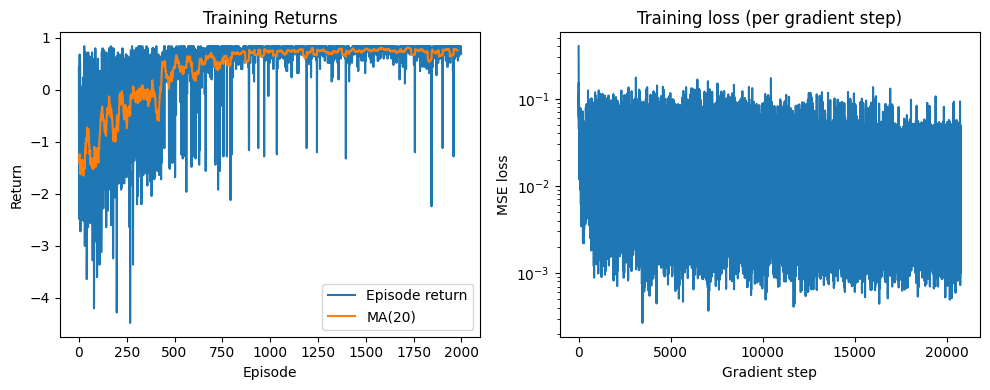

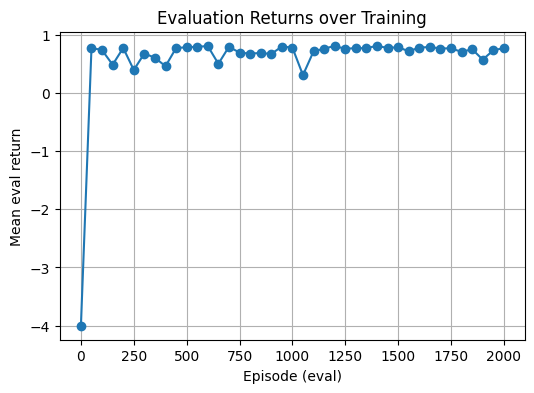

In [8]:
# Cell 8 — Plot learning curves
train_returns = results['train_returns']
losses = results['losses']
eval_returns = results['eval_returns']

# Plot 1: moving-average of returns
def moving_average(x, w=20):
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_returns, label='Episode return')
ma = moving_average(train_returns, 20)
plt.plot(range(len(ma)), ma, label='MA(20)')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Training Returns')
plt.legend()

plt.subplot(1,2,2)
if len(losses)>0:
    plt.plot(losses)
    plt.yscale('log')
    plt.xlabel('Gradient step')
    plt.ylabel('MSE loss')
    plt.title('Training loss (per gradient step)')
else:
    plt.text(0.5,0.5,'No loss recorded', ha='center')
plt.tight_layout()
plt.show()

# Plot evaluation returns
if len(eval_returns)>0:
    eps_list = [e[0] for e in eval_returns]
    eval_means = [e[1] for e in eval_returns]
    plt.figure(figsize=(6,4))
    plt.plot(eps_list, eval_means, marker='o')
    plt.xlabel('Episode (eval)')
    plt.ylabel('Mean eval return')
    plt.title('Evaluation Returns over Training')
    plt.grid(True)
    plt.show()


In [9]:
# Cell 9 — Save the model and figures
os.makedirs('output', exist_ok=True)
torch.save(results['Q'].state_dict(), 'output/qnet_model.pth')
# Save plots to disk as well
plt.figure(figsize=(8,3))
plt.plot(train_returns, label='Episode return')
ma = moving_average(train_returns, 20)
plt.plot(range(len(ma)), ma, label='MA(20)')
plt.legend()
plt.title('Training Returns')
plt.savefig('output/training_returns.png', dpi=150)
plt.close()

if len(losses)>0:
    plt.figure(figsize=(8,3))
    plt.plot(losses)
    plt.yscale('log')
    plt.title('Loss per gradient step')
    plt.savefig('output/loss_curve.png', dpi=150)
    plt.close()

print("Saved model and plots to /content/output/")


Saved model and plots to /content/output/


In [10]:
# Cell 10 — Quick policy visualization (print chosen actions at each cell)
# Map actions to letters
action_map = {0:'N',1:'S',2:'E',3:'W'}
qnet = results['Q']
qnet.eval()
policy_grid = [['' for _ in range(env.cols)] for __ in range(env.rows)]
for r in range(env.rows):
    for c in range(env.cols):
        pos = (r,c)
        if env.is_terminal_pos(pos):
            policy_grid[r][c] = 'G' if pos==env.terminal_goal else 'T'
        else:
            vec = np.zeros(env.state_size, dtype=np.float32)
            vec[env._pos_to_index(pos)] = 1.0
            s_t = torch.tensor(vec, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                qvals = qnet(s_t)
            a = int(torch.argmax(qvals, dim=1).item())
            policy_grid[r][c] = action_map[a]

print("Policy grid (rows top->bottom):")
for row in policy_grid:
    print(row)


Policy grid (rows top->bottom):
['E', 'E', 'E', 'G']
['N', 'N', 'W', 'T']
['N', 'N', 'W', 'S']
